In [267]:
#https://www.zybuluo.com/hanbingtao/note/485480
#卷积神经网络(Convolutional Neural Network, CNN)

#数据下载
# from tensorflow.examples.tutorials.mnist import input_data
# mnist=input_data.read_data_sets('/tmp/',one_hot=True)
#或者：download:http://yann.lecun.com/exdb/mnist/

#文件路径
import os

base_path='/Users/yexianyong/Downloads/machine_learning/mnist'
training_images_path=os.path.join(base_path,'train-images-idx3-ubyte')
training_labels_path=os.path.join(base_path,'train-labels-idx1-ubyte')
test_images_path=os.path.join(base_path,'t10k-images-idx3-ubyte')
test_labels_path=os.path.join(base_path,'t10k-labels-idx1-ubyte')

training_images_path

'/Users/yexianyong/Downloads/machine_learning/mnist/train-images-idx3-ubyte'

In [268]:
#读取文件
#http://blog.csdn.net/simple_the_best/article/details/75267863
import struct
import numpy as np

def load_mnist(images_path,labels_path,kind='train'):
    """Load MNIST data from path"""
    
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath,dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16))
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)

    return images, labels
images,labels=load_mnist(training_images_path,training_labels_path)
images,labels

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([5, 0, 4, ..., 5, 6, 8], dtype=uint8))

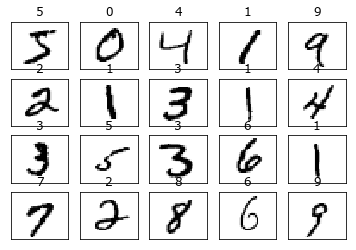

In [269]:
#可视化
import matplotlib.pyplot as plt
fig,ax=plt.subplots(nrows=4,ncols=5,sharex=True,sharey=True)

ax = ax.flatten()
for i in range(20):
    img = images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(labels[i])
    
ax[0].set_xticks([])
ax[0].set_yticks([])

plt.show()

# 卷积测试

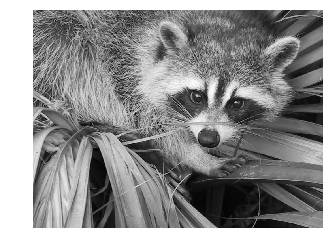

(768, 1024)

In [319]:
def show(img):
    fig,ax=plt.subplots()
    imgplot=plt.imshow(img)
    ax.set_axis_off()
    plt.gray()
    plt.show()


from scipy import signal,misc
img=misc.face(gray=True)
show(img)
img.shape

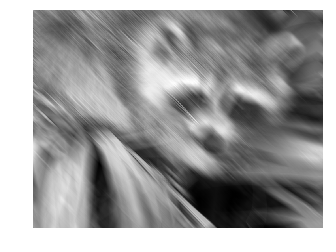

In [328]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html
#对于boundary和fillvalue的说明：
#当boundary=‘fill’的时候，fillvalue才会生效,fillvalue默认0

feature=signal.convolve2d(img,np.eye(50),mode='same',boundary='symm')
show(feature)

# 池化
### 常见的池化操作有：
---
**平均池化(mean polling):**计算图像区域的平均值作为该区域池化后的值;

**最大池化（max pooling）:**选图像区域的最大值作为该区域池化后的值；

**重叠池化（overlapping pooling）：**相邻池化窗口之间会有重叠区域；

**空间金字塔池化（spatial pyramid pooling）：**空间金字塔池化，使得任意大小的特征图都能够转换成固定大小的特征向量，这就是空间金字塔池化的意义（多尺度特征提取出固定大小的特征向量），送入全连接层。

### 空间金字塔池化如何提取特征，得到固定大小的特征向量？
---
我们假设一个很简单两层网络：输入一张任意大小的图片,假设其大小为(w,h)，输出21个神经元。也就是我们输入一张任意大小的特征图的时候，我们希望提取出21个特征。空间金字塔特征提取的过程如下：
![](http://img.blog.csdn.net/20160511195707981)
如上图所示，当我们输入一张图片的时候，我们利用不同大小的刻度，对一张图片进行了划分。上面示意图中，利用了三种不同大小的刻度（4*4,2*2,1*1），对一张输入的图片进行了划分，最后总共可以得到16+4+1=21个块，我们即将从这21个块中，每个块提取出一个特征，这样刚好就是我们要提取的21维特征向量。
引用自[空间金字塔池化](http://blog.csdn.net/u013110060/article/details/61199597)


In [272]:
np.random.seed(1)
arr=np.random.choice(10,(4,4))
arr

array([[5, 8, 9, 5],
       [0, 0, 1, 7],
       [6, 9, 2, 4],
       [5, 2, 4, 2]])

In [273]:
from skimage import measure
arr_poolinged=measure.block_reduce(arr,(2,2),np.max)
arr_poolinged

array([[8, 9],
       [9, 4]])

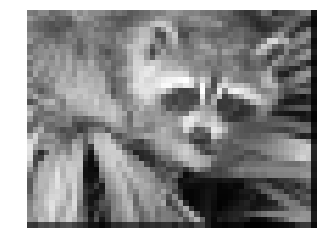

(39, 52)

In [274]:
#平均池化
img_poolinged=measure.block_reduce(img,(20,20),np.mean)
show(img_poolinged)
img_poolinged.shape

# 正式开始

### [超参数如何确定](https://www.zhihu.com/question/38098038)

[卷积神经网络CNN:Tensorflow实现(以及对卷积特征的可视化)](http://blog.csdn.net/u014281392/article/details/74316028)

![](http://img.blog.csdn.net/20170704150529685?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvdTAxNDI4MTM5Mg==/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast)

**总之：卷积核，越小越好，降低参数数量，降低复杂度。**

### 步骤
* 卷积
* 非线性(ReLU)
* 池化或下采样
* 分类（全连接层）

In [337]:
#激活函数
def relu(x):
    return max(0,x)

#初始化

#First convolutional layer 
#六个卷积核
num_1=6
filters_1=[np.random.rand(5,5) for _ in range(num_1)]
biass_1=np.random.rand(num_1)
print(len(filters_1),biass_1)

#Second convolutional layer
#12个卷积核
num_2=32
filters_2=[np.random.rand(5,5) for _ in range(num_2)]
biass_2=np.random.rand(num_2)
print(len(filters_2),biass_2)

6 [0.6  0.61 0.38 0.23 0.39 0.97]
32 [0.58 0.79 0.4  0.99 0.06 0.13 0.01 0.96 0.95 0.69 0.59 0.68 0.47 0.68
 0.74 0.25 0.98 0.42 0.66 0.3  0.28 0.52 0.69 0.44 0.22 0.49 0.99 0.9
 0.87 0.88 0.5  0.04]


原图


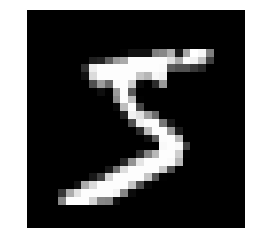

(28, 28) (14, 14)


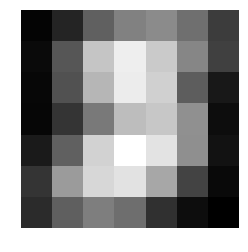

(28, 28) (14, 14)


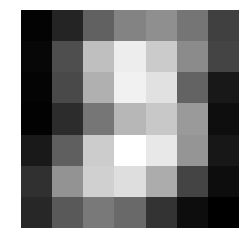

(28, 28) (14, 14)


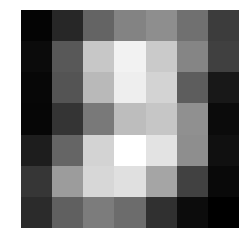

(28, 28) (14, 14)


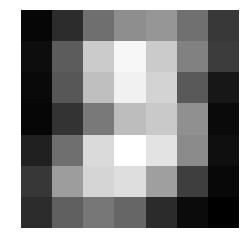

(28, 28) (14, 14)


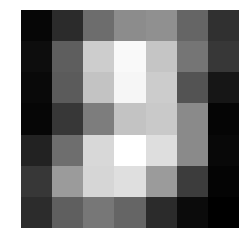

(28, 28) (14, 14)


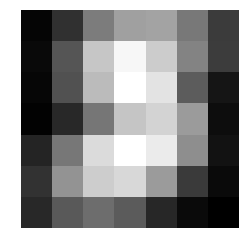

In [338]:

for temp_img,lab in zip(images,labels):
    img=temp_img.reshape(28,28)
    print('原图'),show(img)
    
    
    
    #First convolutional layer 
    
    
    #Second convolutioal layer
    
    
    
    
    
    
    
    #First convolutional layer 
    #使用filters_c1中的六个卷积核分别卷积原图

    
    

#     for index in range(len(filters_1)):
        
#         #First convolution layer
#         conved_1=signal.convolve2d(img,filters_c1[index],mode='same')+biass_2[index]
#         pooled_1=measure.block_reduce(conved_1,(2,2),np.max)
        
#         print(conved_1.shape,pooled_1.shape)
# #         show(pooleds_1[0])
        
        
#         #用filters_2里面的卷积核分别去卷积pooled_1
#         for index in range(len(filters_2)):
#             #Second convolutioal layer
#             conved_2=signal.convolve2d(pooled_1,filters_2[index],mode='same')+biass_2[index]
#             pooled_2=measure.block_reduce(conved_2,(2,2),np.max)
            
#             show(pooled_2)
            
#             #接下来全连接
            
            
            
            
#             break
    

    
#     break

    
    
    
